<a href="https://colab.research.google.com/github/christmasv/Entendiendo-Machine-Learning-desde-Cero/blob/main/Christopher_Soto_Homework_image_classification_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificación de imágenes desde cero

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2020/04/27<br>
**Last modified:** 2020/04/28<br>


**Tarea UNI Nicaragua**

 Author = [Christopher Soto](https://twitter.com/csv_81),

    @article{khrizoto,     
    Title        = {Clasificación de imágenes desde cero},
    Howpublished = {\url{https://khrizoto.wordpress.com/}},
    Year         = {2022}
}
**Descripción:** Entrenando un clasificador de imágenes desde cero en el dataset Kaggle Cats vs Dogs.

# **Introducción**
Este ejemplo muestra cómo realizar una clasificación de imágenes desde cero, a partir de archivos de imagen JPEG en el disco, sin aprovechar pesos previamente entrenados o un modelo de aplicación Keras prefabricado. Se observa el flujo de trabajo en el conjunto de datos de clasificación binaria `Kaggle` `Cats` vs `Dogs`.

Usamos la **image_dataset_from_directoryutilidad **para generar los conjuntos de datos y usamos las capas de preprocesamiento de imágenes de Keras para la estandarización de imágenes y el aumento de datos


## Configuración


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


## Clasificación de imágenes desde cero

### Descargamos base de imagenes sin procesar

Archivo ZIP 786M conteniendo imagenes sin procesar.  Origen Kaggle:


In [2]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   158M      0  0:00:04  0:00:04 --:--:--  167M


In [3]:
#Descomprimir archivo y visualizar directorio

!unzip -q kagglecatsanddogs_5340.zip
!ls


 CDLA-Permissive-2.0.pdf      PetImages        sample_data
 kagglecatsanddogs_5340.zip  'readme[1].txt'


Ahora tenemos una `PetImagescarpeta` que contiene dos subcarpetas `Cat` y `Dog`. Cada subcarpeta contiene archivos de imagen para cada categoría.


In [4]:
!ls PetImages


Cat  Dog


### Filtrar imágenes corruptas o dañadas
Cuando se trabaja con muchos datos de imágenes del mundo real, las imágenes dañadas es común encontralas. Filtremos las imágenes mal codificadas que no tengan la cadena "JFIF" en su encabezado.

In [5]:
#Importamos Lib/os.py [Este módulo provee una manera versátil de usar funcionalidades dependientes del sistema operativo.]

import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Eliminamos imagenes corruptas o dañadas
            os.remove(fpath)

print("Deleted %d images" % num_skipped)


Deleted 1590 images


## Generamos el `Dataset`


In [6]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


## Visualiza los datos
Aquí están las primeras 9 imágenes en el conjunto de datos de entrenamiento. Como puede ver, la etiqueta 1 es "perro" y la etiqueta 0 es "gato".




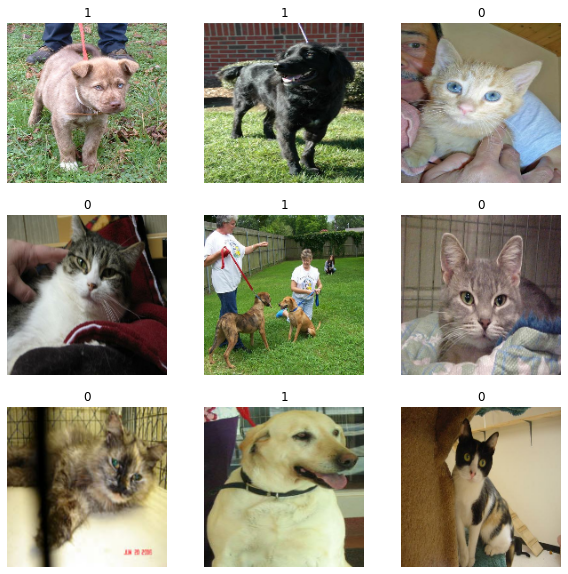

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


## Usando `image data augmentation`

Cuando no tiene un conjunto de datos de imágenes grande, es una buena práctica introducir artificialmente diversidad de muestras aplicando transformaciones aleatorias pero realistas a las imágenes de entrenamiento, como volteos horizontales aleatorios o pequeñas rotaciones aleatorias. Esto ayuda a exponer el modelo a diferentes aspectos de los datos de entrenamiento mientras ralentiza el sobreajuste.

In [8]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)


Visualicemos cómo se ven las muestras aumentadas, aplicándo `data_augmentation` repetidamente a la primera imagen en el conjunto de datos:


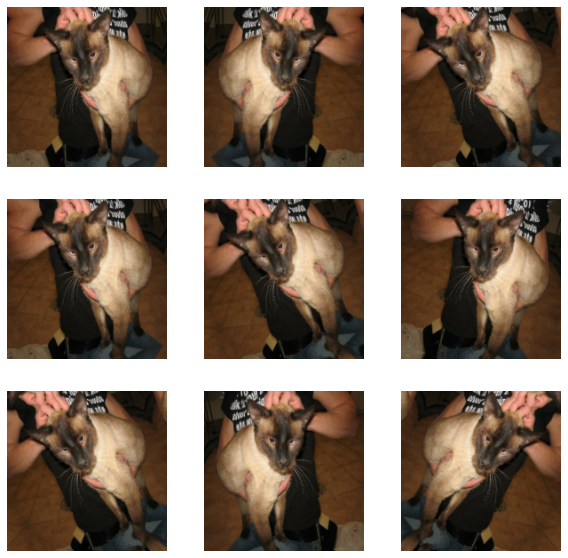

In [9]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


## Estandarizando los datos

Nuestra imagen ya tiene un tamaño estándar (180x180), el atributo `float32` aplicado a nuestro conjunto de datos las produce como lotes contiguos. Sin embargo, sus valores de canal RGB están en el `[0, 255]` rango. Esto no es ideal para una red neuronal; en general, debe buscar que sus valores de entrada sean pequeños. Aquí, estandarizaremos los valores para que estén en el `[0, 1]` mediante el uso de una `Rescaling layer` al comienzo de nuestro modelo.


## Dos opciones para preprocesar los datos

Hay dos formas en que podría estar usando el data_augmentation preprocesador:

**Opción 1: Hazlo parte del "Modelo"**, a continuación:

```python
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
...  # Rest of the model
```

Con esta opción, su aumento de datos ocurrirá en el dispositivo, sincrónicamente con el resto de la ejecución del modelo, lo que significa que se beneficiará de la aceleración de GPU.

Tenga en cuenta que el aumento de datos está inactivo en el momento de la prueba, por lo que las muestras de entrada solo se aumentarán durante `fit()`, no cuando llame `evaluate()` o `predict()`.

Si estás entrenando en GPU, esta es la mejor opción.

**Opción 2: Aplicarlo al conjunto de datos**, para obtener un conjunto de datos que produzca lotes de imágenes aumentadas, como este:

```python
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))
```

Con esta opción, su aumento de datos ocurrirá **en la CPU**, de forma asincrónica, y se almacenará en búfer antes de ingresar al modelo.

Si está entrenando en CPU, esta es la mejor opción, ya que hace que el aumento de datos sea asincrónico y sin bloqueo.

En nuestro caso, nos decantaremos por la primera opción.


## Configurar el conjunto de datos para el rendimiento

Asegurémonos de usar la captación previa almacenada en búfer para que podamos obtener datos del disco sin que la E/S se bloquee:


In [10]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)


## Construir un modelo

Construiremos una versión pequeña de la red Xception. No hemos tratado particularmente de optimizar la arquitectura; si desea realizar una búsqueda sistemática de la mejor configuración de modelo, considere utiliza
[KerasTuner](https://github.com/keras-team/keras-tuner).

Nota:

- Comenzamos el modelo con el `data_augmentation` preprocesador, seguido de una `Rescaling layer`.
- Incluimos una `Dropout layer` antes de la capa de clasificación final.



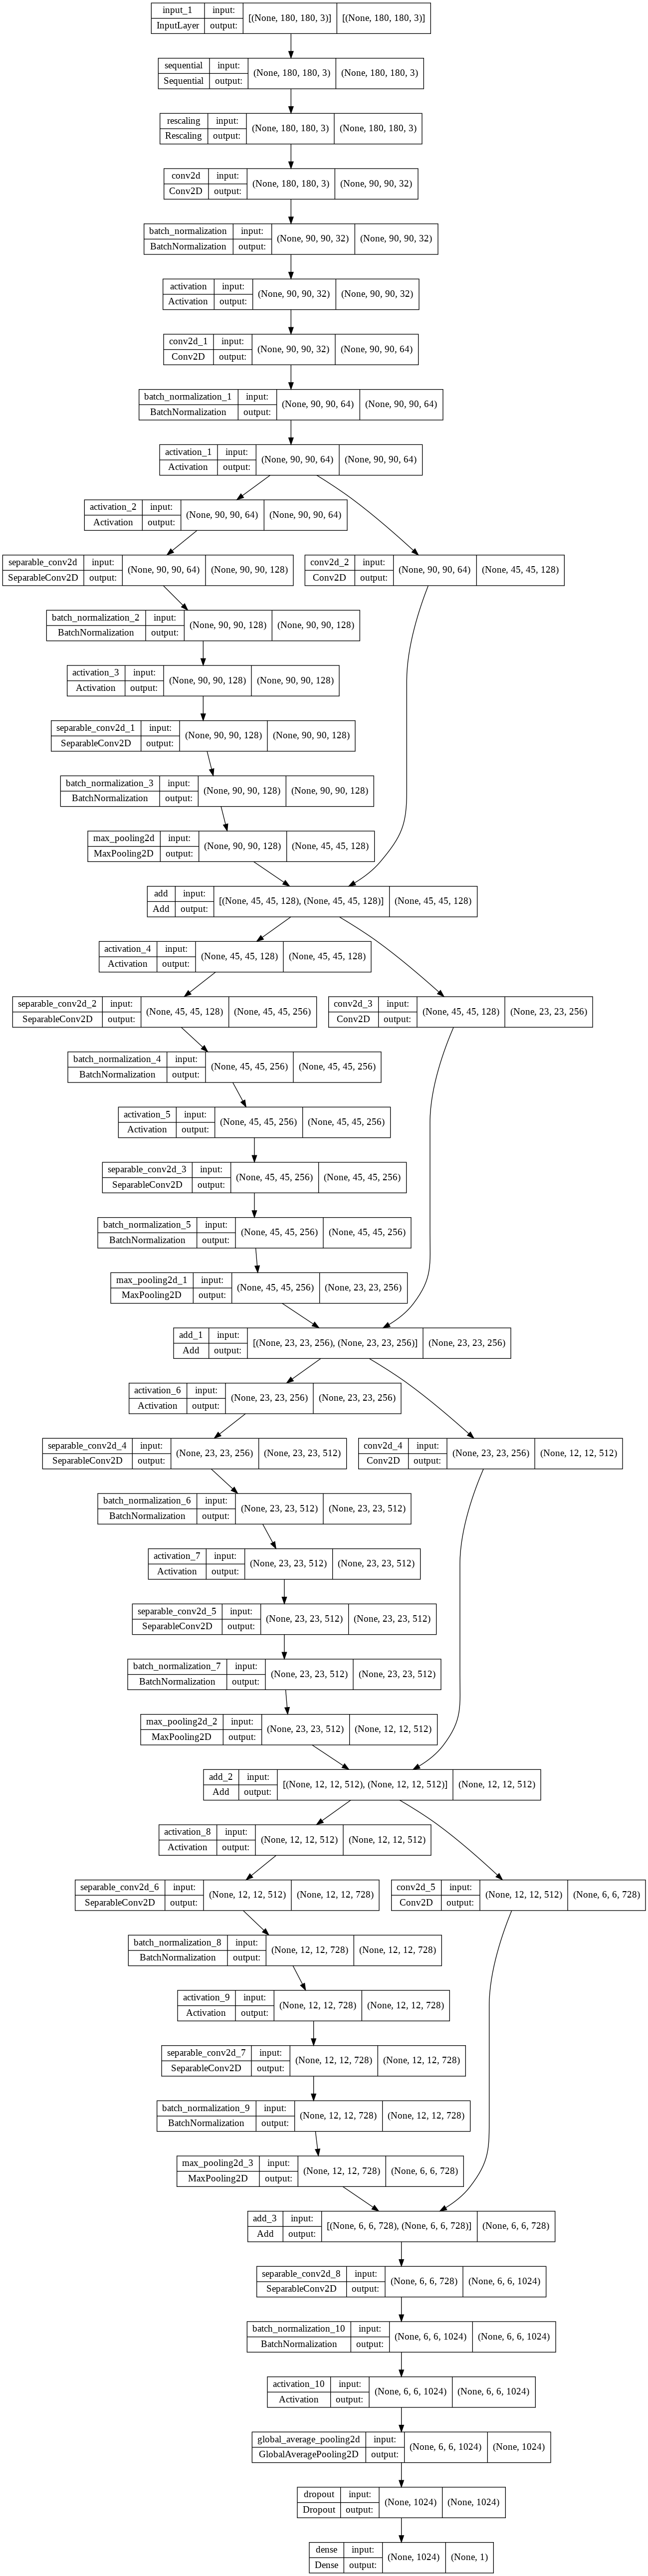

In [11]:

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)


## Entrenamos el model


In [ ]:
epochs = 2

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)


Epoch 1/50
586/586 [==============================] - 5134s 9s/step - loss: 0.6160 - accuracy: 0.6663 - val_loss: 0.7106 - val_accuracy: 0.6249
Epoch 2/50
200/586 [=========>....................] - ETA: 53:57 - loss: 0.5225 - accuracy: 0.7447

KeyboardInterrupt: ignored

Obtenemos una precisión de validación de ~96 % después de entrenar durante 50 épocas en el conjunto de datos completo.


## Ejecutar inferencia en datos nuevos

Tenga en cuenta que el aumento y la eliminación de datos están inactivos en el momento de la inferencia


In [ ]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)
